<a href="https://colab.research.google.com/github/Freesoul-tech/Louis-Mahobe/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

class ScratchLogisticRegression():
    def __init__(self, num_iter=1000, lr=0.01, bias=True, verbose=False, reg_lambda=0.0):
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.reg_lambda = reg_lambda
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _add_bias(self, X):
        if self.bias:
            return np.hstack([np.ones((X.shape[0], 1)), X])
        return X

    def _predict_proba_internal(self, X):
        z = X @ self.coef_
        return self._sigmoid(z)

    def _compute_loss(self, X, y):
        m = len(y)
        h = self._predict_proba_internal(X)
        epsilon = 1e-15
        loss = -np.mean(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
        # Regularization
        if self.bias:
            loss += (self.reg_lambda / (2 * m)) * np.sum(self.coef_[1:] ** 2)
        else:
            loss += (self.reg_lambda / (2 * m)) * np.sum(self.coef_ ** 2)
        return loss

    def _gradient_descent(self, X, y):
        m = len(y)
        h = self._predict_proba_internal(X)
        error = h - y
        grad = (X.T @ error) / m
        # Regularization
        if self.bias:
            grad[1:] += (self.reg_lambda / m) * self.coef_[1:]
        else:
            grad += (self.reg_lambda / m) * self.coef_
        self.coef_ -= self.lr * grad

    def fit(self, X, y, X_val=None, y_val=None):
        X = self._add_bias(X)
        if X_val is not None:
            X_val = self._add_bias(X_val)
        self.coef_ = np.zeros(X.shape[1])

        for i in range(self.iter):
            self._gradient_descent(X, y)
            self.loss[i] = self._compute_loss(X, y)
            if X_val is not None and y_val is not None:
                self.val_loss[i] = self._compute_loss(X_val, y_val)
            if self.verbose and i % 100 == 0:
                print(f"Iter {i}: Train Loss = {self.loss[i]:.4f}", end="")
                if X_val is not None:
                    print(f", Val Loss = {self.val_loss[i]:.4f}")
                else:
                    print()

    def predict_proba(self, X):
        X = self._add_bias(X)
        return self._predict_proba_internal(X)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)


In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load and filter dataset
iris = load_iris()
X = iris.data
y = iris.target

# Binary classification
X = X[y != 0]
y = y[y != 0]
y = (y == 2).astype(int)


X = X[:, [1, 2]]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [4]:
model = ScratchLogisticRegression(num_iter=1000, lr=0.1, bias=True, verbose=True, reg_lambda=0.1)
model.fit(X_train, y_train, X_val, y_val)


Iter 0: Train Loss = 0.6753, Val Loss = 0.6761
Iter 100: Train Loss = 0.2887, Val Loss = 0.3524
Iter 200: Train Loss = 0.2247, Val Loss = 0.3188
Iter 300: Train Loss = 0.1953, Val Loss = 0.3110
Iter 400: Train Loss = 0.1782, Val Loss = 0.3113
Iter 500: Train Loss = 0.1671, Val Loss = 0.3149
Iter 600: Train Loss = 0.1593, Val Loss = 0.3197
Iter 700: Train Loss = 0.1537, Val Loss = 0.3250
Iter 800: Train Loss = 0.1494, Val Loss = 0.3304
Iter 900: Train Loss = 0.1461, Val Loss = 0.3356


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))


Accuracy: 0.8333333333333334
Precision: 0.8333333333333334
Recall: 0.7692307692307693


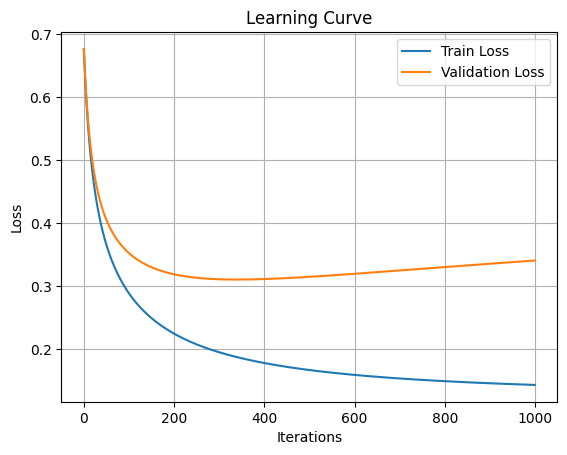

In [6]:
import matplotlib.pyplot as plt

plt.plot(model.loss, label="Train Loss")
plt.plot(model.val_loss, label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


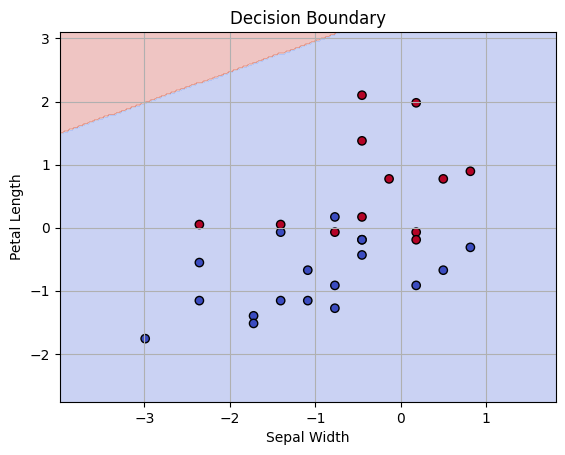

In [7]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid)
    Z = model.predict(grid_scaled).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.xlabel("Sepal Width")
    plt.ylabel("Petal Length")
    plt.title("Decision Boundary")
    plt.grid(True)
    plt.show()

plot_decision_boundary(model, X_val, y_val)


In [8]:
# Save weights
np.savez("logistic_weights.npz", coef=model.coef_)

# Load weights
loaded = np.load("logistic_weights.npz")
model.coef_ = loaded["coef"]


In [9]:
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression(penalty='l2', C=1/0.1, fit_intercept=True, solver='lbfgs')
sk_model.fit(X_train, y_train)


LogisticRegression(C=10.0)

In [10]:
y_sk_pred = sk_model.predict(X_val)

print("Sklearn Accuracy:", accuracy_score(y_val, y_sk_pred))
print("Sklearn Precision:", precision_score(y_val, y_sk_pred))
print("Sklearn Recall:", recall_score(y_val, y_sk_pred))


Sklearn Accuracy: 0.8
Sklearn Precision: 0.7333333333333333
Sklearn Recall: 0.8461538461538461


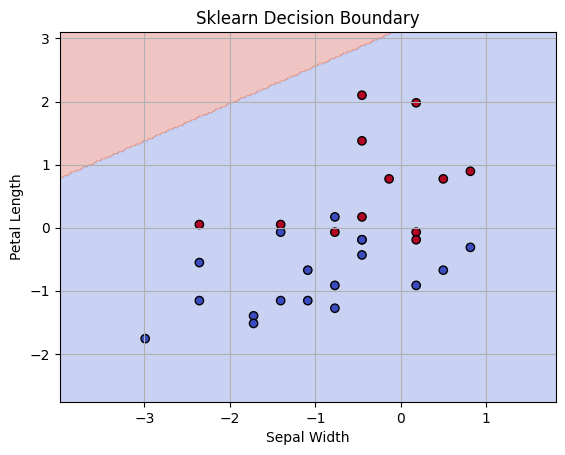

In [11]:
def plot_decision_boundary_sklearn(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid)
    Z = model.predict(grid_scaled).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.xlabel("Sepal Width")
    plt.ylabel("Petal Length")
    plt.title("Sklearn Decision Boundary")
    plt.grid(True)
    plt.show()

plot_decision_boundary_sklearn(sk_model, X_val, y_val)
